In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/ICT/dataset/PlantVillage.zip'
extract_path = '/content/drive/MyDrive/ICT/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

KeyboardInterrupt: 

#Data preprocessing

## Resize & Convert Images to Array

In [ ]:
import os

data = []
labels = []
image_size = 64

dataset_path = "/content/drive/MyDrive/ICT/dataset/PlantVillage"

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        try:
            img_arr = cv2.imread(img_path)
            img_arr = cv2.resize(img_arr, (image_size, image_size))
            data.append(img_arr)
            labels.append(category)
        except:
            pass

data = np.array(data) / 255.0
labels = np.array(labels)

##Label encoding

In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

##Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

#Feature extraction -
#### for SVM and Random Forest

In [ ]:
def extract_features(img):
    # Ensure img is in [0, 1]
    if img.max() > 1.0:
        img = img / 255.0
    img_uint8 = (img * 255).astype(np.uint8)

    # Convert to grayscale safely
    if len(img_uint8.shape) == 3 and img_uint8.shape[2] == 3:
        img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_uint8

    # Compute & normalize histogram
    hist = cv2.calcHist([img_gray], [0], None, [64], [0, 256])
    hist = cv2.normalize(hist, None).flatten()
    return hist

X_features = np.array([extract_features(img) for img in data])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

##Histogram

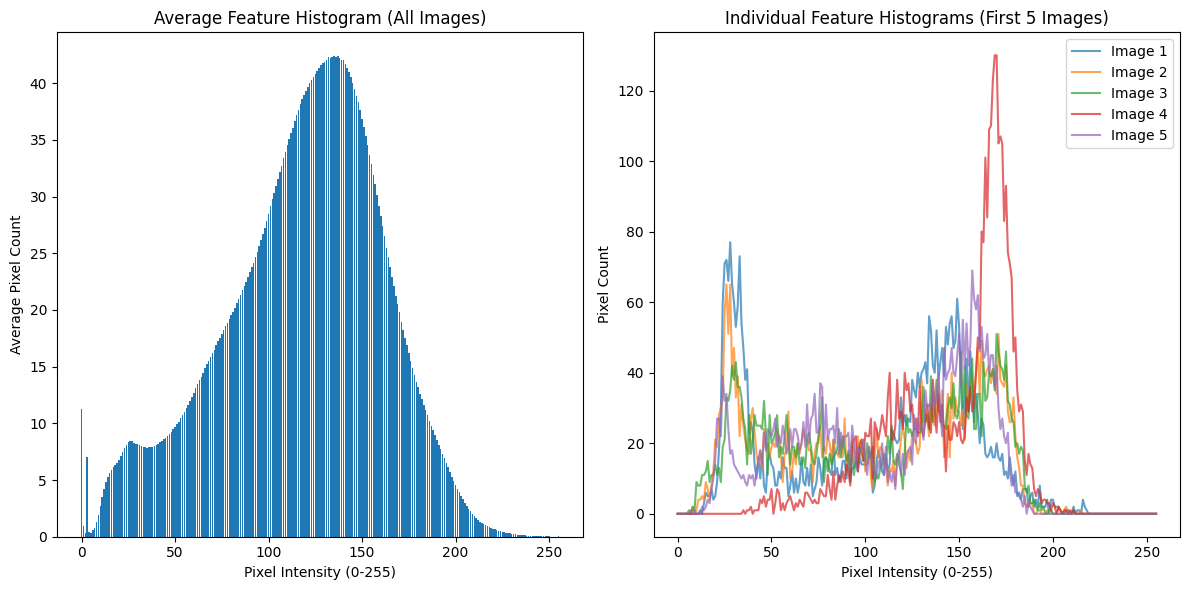

In [ ]:
#Instead of feeding raw image arrays (which are large), you're extracting simpler features (histogram of grayscale intensities) for classical ML models (like SVM, KNN, etc.).
#This is useful when you want to use machine learning without deep learning.

def extract_features(img):
    img_uint8 = (img * 255).astype(np.uint8)                            # Convert from float64 to uint8.

    #OpenCV's functions like cv2.cvtColor() expect image data in uint8 format in range [0, 255], so you scale it back.

    img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)              #Converts the image to grayscale (single channel)

    #only need intensity values (not color) to compute a histogram.

    hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])

    #Calculates a grayscale histogram:
    #img_gray: input image.
    #[0]: channel index (only 1 channel in grayscale).
    #None: no mask applied (use full image).
    #[256]: 256 bins (0 to 255 pixel values).
    #[0, 256]: range of pixel values.

    #How many pixels in the image have intensity 0, 1, 2, ..., 255

    #result is a 256×1 array showing how many pixels fall into each intensity bucket.

    return hist.flatten()                    #Flattens the 2D histogram array to 1D (shape: (256,))

X_features = np.array([extract_features(img) for img in data])        #Loops through all preprocessed images in data, extracts histogram features, and creates a 2D NumPy array

# Shape: (num_samples, 256)
# This is feature matrix X, which can now be used with classical ML models

# splitting features:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)
# splits the features (X_features) and encoded labels into training and testing sets

# Visualize histogram features
plt.figure(figsize=(12, 6))

# Plot 1: Average histogram across all images
plt.subplot(1, 2, 1)
avg_features = X_features.mean(axis=0)
plt.bar(range(len(avg_features)), avg_features)
plt.title('Average Feature Histogram (All Images)')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Average Pixel Count')

# Plot 2: Feature distribution for first few samples
plt.subplot(1, 2, 2)
for i in range(min(5, len(X_features))):
    plt.plot(X_features[i], alpha=0.7, label=f'Image {i+1}')
plt.title('Individual Feature Histograms (First 5 Images)')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Pixel Count')
plt.legend()

plt.tight_layout()
plt.show()

#Training ML model

## Model 1- Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5)
svm_model.fit(X_train, y_train)

# Evaluate
y_pred_svm = svm_model.predict(X_test)
print("🔹 SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("🔹 Best Params:", svm_model.best_params_)
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_svm))

🔹 SVM Accuracy: 0.5881782945736435
🔹 Best Params: {'C': 10, 'kernel': 'rbf'}
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       199
           1       0.52      0.53      0.53       296
           2       0.63      0.72      0.67       200
           3       0.43      0.35      0.39       200
           4       0.50      0.03      0.06        30
           5       0.73      0.70      0.71       426
           6       0.55      0.40      0.46       200
           7       0.57      0.48      0.52       382
           8       0.60      0.39      0.48       190
           9       0.59      0.53      0.56       354
          10       0.68      0.64      0.66       335
          11       0.58      0.58      0.58       281
          12       0.50      0.67      0.57       642
          13       0.59      0.21      0.31        75
          14       0.63      0.86      0.73       318

    accuracy                   

##Model 2-Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=52)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(" Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(" Classification Report (RF):\n", classification_report(y_test, y_pred_rf))



 Random Forest Accuracy: 0.6145833333333334
 Classification Report (RF):
               precision    recall  f1-score   support

           0       0.73      0.60      0.66       199
           1       0.55      0.57      0.56       296
           2       0.64      0.77      0.70       200
           3       0.55      0.42      0.48       200
           4       1.00      0.03      0.06        30
           5       0.71      0.72      0.72       426
           6       0.59      0.40      0.47       200
           7       0.60      0.49      0.54       382
           8       0.59      0.48      0.53       190
           9       0.58      0.63      0.61       354
          10       0.67      0.66      0.66       335
          11       0.59      0.54      0.56       281
          12       0.54      0.69      0.61       642
          13       0.68      0.35      0.46        75
          14       0.70      0.87      0.78       318

    accuracy                           0.61      4128
   mac

##Model 3-Custom CNN(using raw images)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Prepare data
X = data  # normalized already
y = to_categorical(labels_encoded)  # one-hot encoded labels

X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels_encoded
)

# CNN Model
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')  # number of classes
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN
cnn.fit(X_train_img, y_train_img, epochs=40, batch_size=32, validation_split=0.2)

# Evaluate
cnn_loss, cnn_acc = cnn.evaluate(X_test_img, y_test_img)
print(" CNN Accuracy:", cnn_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 187ms/step - accuracy: 0.3023 - loss: 2.1695 - val_accuracy: 0.6432 - val_loss: 1.0929
Epoch 2/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 83s 191ms/step - accuracy: 0.6147 - loss: 1.1843 - val_accuracy: 0.7644 - val_loss: 0.7179
Epoch 3/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 187ms/step - accuracy: 0.6968 - loss: 0.9180 - val_accuracy: 0.8313 - val_loss: 0.5864
Epoch 4/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 81s 186ms/step - accuracy: 0.7414 - loss: 0.7701 - val_accuracy: 0.8240 - val_loss: 0.5603
Epoch 5/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - accuracy: 0.7694 - loss: 0.6851 - val_accuracy: 0.8313 - val_loss: 0.5401
Epoch 6/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 82s 191ms/step - accuracy: 0.7944 - loss: 0.6045 - val_accuracy: 0.8643 - val_loss: 0.4597
Epoch 7/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 82s 190ms/step - accuracy: 0.8075 - loss: 0.5625 - val_accuracy: 0.8658 - val_loss: 0.4387
Epoch 8/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step - accuracy: 0.8243 - loss: 0

In [ ]:
model_path = "/content/drive/MyDrive/ICT/cnn_model.h5"
cnn.save(model_path)
print(f"Model saved at {model_path}")

Model saved at /content/drive/MyDrive/ICT/cnn_model.h5


In [ ]:
!pip install streamlit -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install gradio -q


In [ ]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from PIL import Image as PILImage

# Load your model and label encoder as before
cnn = load_model("/content/drive/MyDrive/ICT/cnn_model.h5")
class_labels = label_encoder.classes_

def predict_disease_ui(image):
    # Convert PIL image to OpenCV format
    img = np.array(image)
    img_cv2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Preprocess
    img_resized = cv2.resize(img_cv2, (64, 64))
    img_resized = img_resized / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Predict
    predictions = cnn.predict(img_input)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    class_name = label_encoder.inverse_transform([predicted_class])[0]

    # Top 3
    top_indices = np.argsort(predictions[0])[::-1][:3]
    top_results = "\n".join(
        [f"{i+1}. {label_encoder.inverse_transform([idx])[0]} - {predictions[0][idx]:.2%}"
         for i, idx in enumerate(top_indices)]
    )

    result_text = (
        f"Class: {class_name}\n"
        f"Confidence: {confidence:.2%}\n\n"
        f"Top Predictions:\n{top_results}"
    )

    return result_text

# Gradio UI
gr.Interface(
    fn=predict_disease_ui,
    inputs=gr.Image(type="pil", label="Upload Leaf Image"),
    outputs=gr.Textbox(label="Prediction Results"),
    title="🌿 Plant Leaf Disease Predictor",
    description="Upload an image of a plant leaf. The model will detect possible diseases and show the top predictions."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ad0403250668b8eea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Please upload an image of a plant leaf for disease prediction:


Saving 1ade72cf-f7e0-4282-92d9-614bf05289a0___NREC_B.Spot 1975.JPG to 1ade72cf-f7e0-4282-92d9-614bf05289a0___NREC_B.Spot 1975.JPG
Uploaded image: 1ade72cf-f7e0-4282-92d9-614bf05289a0___NREC_B.Spot 1975.JPG


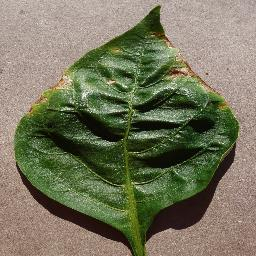

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Prediction Results:
Class: Pepper__bell___Bacterial_spot
Confidence: 100.00%

Top Predictions:
1. Pepper__bell___Bacterial_spot - 100.00%
2. Pepper__bell___healthy - 0.00%
3. Potato___healthy - 0.00%


In [ ]:
from google.colab import files
from IPython.display import Image, display
import numpy as np
import cv2

def predict_disease():
    # Upload image
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Display the uploaded image
        print(f"Uploaded image: {filename}")
        display(Image(filename))

        # Preprocess the image
        img = cv2.imread(filename)
        if img is None:
            print("Error: Could not read the image file.")
            return

        img = cv2.resize(img, (64, 64))  # Resize to match model input
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Make prediction
        predictions = cnn.predict(img)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])

        # Get class name
        class_name = label_encoder.inverse_transform([predicted_class])[0]

        # Display results
        print("\nPrediction Results:")
        print(f"Class: {class_name}")
        print(f"Confidence: {confidence:.2%}")
        print("\nTop Predictions:")

        # Get top 3 predictions
        top_indices = np.argsort(predictions[0])[::-1][:3]
        for i, idx in enumerate(top_indices):
            print(f"{i+1}. {label_encoder.inverse_transform([idx])[0]} - {predictions[0][idx]:.2%}")

# Run the prediction function
print("Please upload an image of a plant leaf for disease prediction:")
predict_disease()